## Project - Movielens 영화 SBR

**Movielens 1M Dataset**을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

## 모듈 import


In [1]:
import datetime as dt
from pathlib import Path
import os
print("file path 모듈 import")

import numpy as np
import pandas as pd
import time                    # 시간 관련
from time import localtime     # 시간 관련
import datetime                # 시간 관련

import warnings
warnings.filterwarnings('ignore')
print("Data 모듈 import")


import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

print("Model Architecture 구성 모듈 import")


file path 모듈 import
Data 모듈 import
Model Architecture 구성 모듈 import


pathlib와 os 모듈을 이용해 Movie len 데이터를 가지고 옵니다.


## Data Load

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']  # column 인덱스 명 지정
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique() 

(6040, 3706)

세션의 용도로 사용할 UserId가 6000개, 아이템 숫자는 3706개가 됩니다.

UserId별 Rating를 값을 살펴봐서 낮은 Rating 점수를 가진 ItemId에 해당하는 영화와 비슷한 영화는 추천하지 않는 방법을 쓸 수 있겠네요.

## 1. 데이터의 전처리
session length, session time, cleaning 등의 작업을 진행합니다.  

### &nbsp; 1.1 Session Length &  User Rating


userId를 SessionId으로 판단하여 session으로 생각해서 데이터 전처리를 진행하겠습니다.  

각 세션(UserId)가 몇개의 영화 데이터를 갖는지 살펴보겠습니다.

한 유저당 rating의 평균과 시간별 rating을 부여한 값을 구해봅시다.

In [4]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

여기서 **session_length**란 같은 **UserId**를 공유하는 데이터 row의 개수를 의미합니다. 

영화의 데이터를 **UserId** 기준으로 모아서 분류해 봅시다.  
그리고 **session_length**란 해당 사용자가 어떤 영화를 시청했는지의 의미가 됩니다.

In [5]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [6]:
session_length.min(), session_length.max()

(20, 2314)

In [7]:
session_length.quantile(0.999)

1343.181000000005

In [8]:
session_length.quantile(0.9999)

2033.790399999547

한 유저당 세션의 길이는 대략 96~166 정도입니다. Movielens가 영화에 대한 추천 커뮤니티 이다보니 평균 165의 많은 리뷰를 남겼네요.

그리고 session_length의 분위수(quantile)를 살펴보면 데이터의 99.9% 세션은 길이가 1344이하입니다.

99.9%의 세션이 1344이하인데 가장 긴 세션 길이가 2314나 되니 한번 살펴봐야될 것 같습니다.

In [9]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session ].head(10)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
696168,4169,3801,5,965333481
696250,4169,3841,2,965333481
697903,4169,3761,3,965333481
697954,4169,3788,3,965333481
695653,4169,3794,4,965333519


데이터를 살펴보니 같은 시간 초에 영화(ItemId) 여러개를 한번에 등록 했네요.   
그리고 데이터의 Time를 살펴보니 이상한 느낌이 드네요. 

4169의 Id를 가진 사용자가 미리 영화 Rating을 지정하고 한번에 올리는 방법을 했을 수도 있으니 다른 사용자를 살펴보겠습니다.

In [10]:
mean_session = session_length[session_length==165].index[0]
data[data['UserId']==mean_session ].head(10)

,UserId,ItemId,Rating,Time
146093,939,480,4,975172890
146114,939,2329,3,975172891
146053,939,1617,4,975172935
146075,939,3476,3,975172935
146088,939,1136,4,975172935
146113,939,3126,4,975172935
146144,939,1955,3,975172935
146110,939,3893,4,975173038
146112,939,3897,5,975173038
146181,939,3910,4,975173038


In [11]:
median_session = session_length[session_length==96].index[0]
data[data['UserId']==long_session ].head(10)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
696168,4169,3801,5,965333481
696250,4169,3841,2,965333481
697903,4169,3761,3,965333481
697954,4169,3788,3,965333481
695653,4169,3794,4,965333519


다른 데이터도 같은 시간에 여러개의 영화 리뷰가 올라와 있네요.  
전체 데이터를 수치화해서 판단해 봅시다.  
**UserId**와 **Time**을 gropu해줘서 문제가 있는지 살펴보고 혹시 모르니 다른 데이터도 group해주어서 살펴봅시다.

In [12]:
session_time_count = data.groupby(['UserId', 'Time']).size()
session_time_count

UserId  Time     
1       978300019    1
        978300055    3
        978300103    1
        978300172    1
        978300275    1
                    ..
6040    997454398    1
        997454429    1
        997454464    2
        997454486    1
        998315055    1
Length: 471163, dtype: int64

In [13]:
session_rating_count = data.groupby(['UserId', 'Rating']).size()
session_rating_count

UserId  Rating
1       3           8
        4          27
        5          18
2       1           2
        2          11
                 ... 
6040    1          27
        2          38
        3          63
        4         137
        5          76
Length: 28370, dtype: int64

In [14]:
session_time_count.median(), session_time_count.mean()

(2.0, 2.1228513274599234)

In [15]:
session_time_count.min(), session_time_count.max()

(1, 30)

In [16]:
# 한명의 유저가 평점을 매길떄의 중앙값, 평균 점수
session_rating_count.median(), session_rating_count.mean()

(16.0, 35.25586887557279)

In [17]:
session_rating_count.min(), session_rating_count.max()

(1, 945)

위의 **session_time_count**에서 max()값이 이상하네요.  
**UserId**와 **Time**를 gropu화의 의미는 한 유저가 해당 시간에 몇개의 영화 평점을 했는지 입니다.  그런데 초 단위의 시간에서 30개의 데이터가 같은 시간에 올라갔다는게 이상하게 여겨집니다.

In [18]:
session_time_count.quantile(0.999)

10.0

- 99.9 미만의 분위수 값이 10이네요. 같은 시간에 여러개의 영화 리뷰를 남긴 데이터들을 모두 제거하겠습니다.

위의 값을 이상치로 판단해 동일한 시간에 한 데이터의 경우 1개만 남기겠습니다.

In [19]:
data = data.drop_duplicates(subset=['UserId', 'Time'], keep='first')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
...,...,...,...,...
999923,6040,232,5,997454398
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000167,6040,161,3,997454486


In [20]:
session_rating_count.median(), session_rating_count.mean()

(16.0, 35.25586887557279)

In [21]:
session_rating_count.min() , session_rating_count.max()

(1, 945)

#### 누적합 cumsum() 

세션 길이에 대해 더 잘 파악하기 위해 시각화를 해보겠습니다. 아래는 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것입니다.

In [22]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1521    0.999338
1595    0.999503
1743    0.999669
1850    0.999834
2314    1.000000
Length: 743, dtype: float64

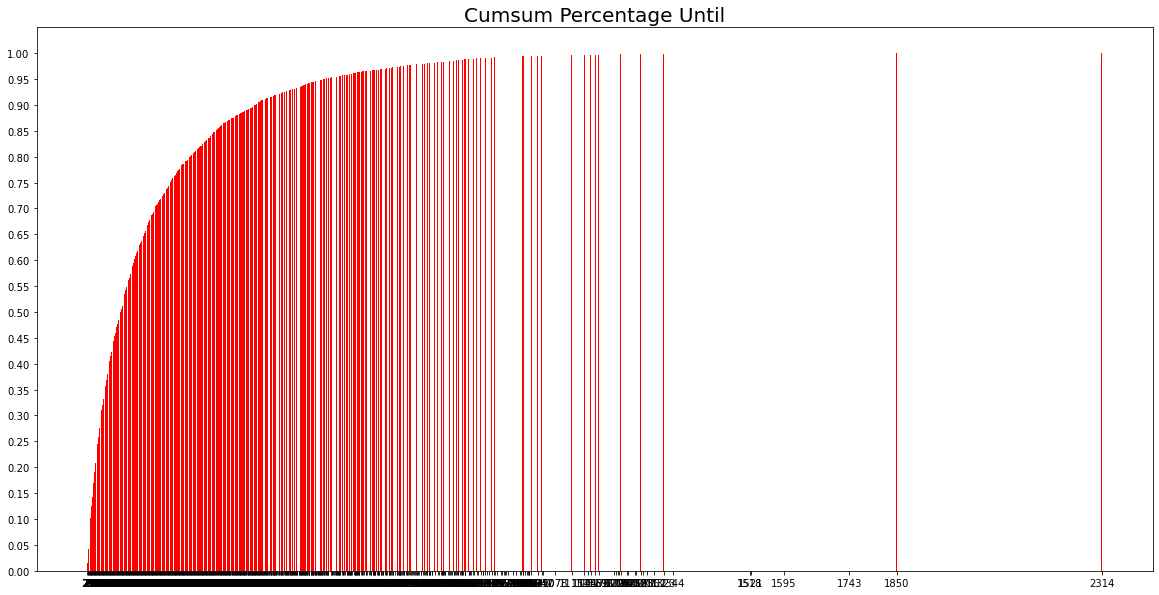

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum, color='red')
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until', size=20)
plt.show()

분위수 99.9 미만 데이터를 제거하지 않고 시각화를 하니 데이터의 분포가 안정적이지 못하네요.  
가장 긴 데이터를 제외해서 진행하겠습니다.
99.99 미만의 데이터만 살리겠습니다.

In [23]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_9999 = length_percent_cumsum[length_percent_cumsum < 0.9999]
length_percent_cumsum_9999[-1:]

1850    0.999834
dtype: float64

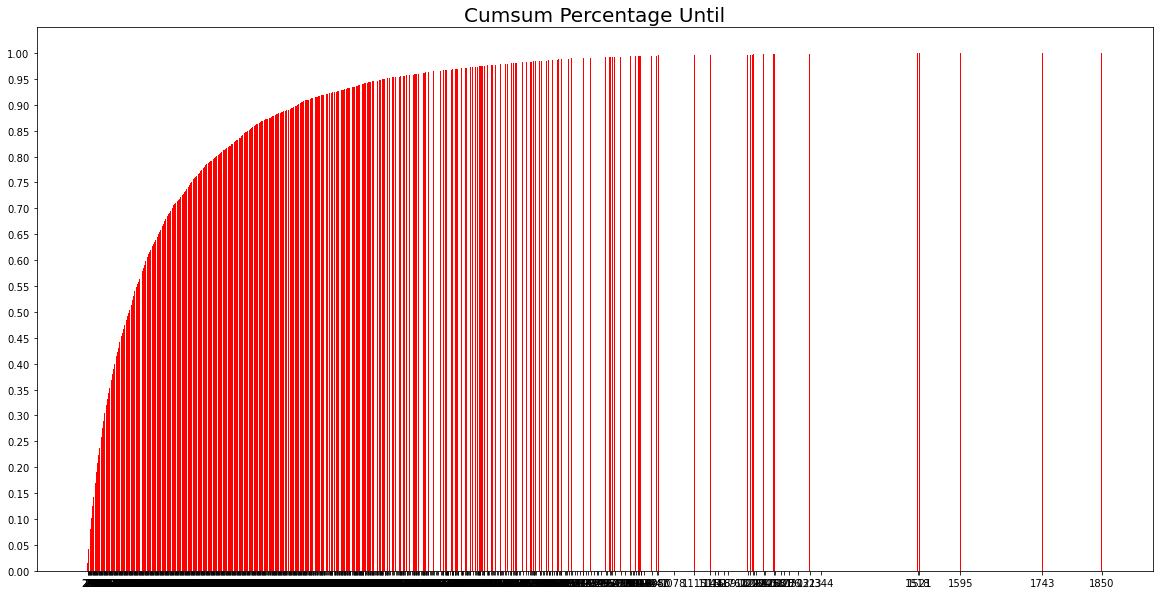

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_9999.index,
        height=length_percent_cumsum_9999, color='red')
plt.xticks(length_percent_cumsum_9999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until', size=20)
plt.show()

99.99 미만 데이터를 사용하니 더 안정적으로 보이네요.  
이 데이터 분포를 가지고 진행하겠습니다.

위의 데이터에서 data의 Time을 UTC 초 단위가 아닌 datetime 객체로 변환을 한 후 년-원-일로 변환하겠습니다.

In [24]:
# int 형식을 가진 데이터로 변환
# strftime로 문자열로 변환한 후 int로 매핑을 해준다.
def strTime2datetime(data_times):
    result =[]
    for data_time in data_times : 
        str_time = time.strftime('%Y-%m-%d %H:%M:%S', localtime(data_time)) # str 형태로 변환
        str_To_datatime = datetime.datetime.strptime(str_time, '%Y-%m-%d %H:%M:%S') 
        result.append(str_To_datatime)
    return result


Time2datetime = strTime2datetime(data['Time'])

Time2datetime[:5]

[datetime.datetime(2001, 1, 1, 7, 0, 19),
 datetime.datetime(2001, 1, 1, 7, 0, 55),
 datetime.datetime(2001, 1, 1, 7, 1, 43),
 datetime.datetime(2001, 1, 1, 7, 2, 52),
 datetime.datetime(2001, 1, 1, 7, 4, 35)]

In [25]:
data['Time'] = Time2datetime
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
36,1,1836,5,2001-01-01 07:02:52
3,1,3408,4,2001-01-01 07:04:35


In [26]:
data.shape

(471163, 4)

### 1.2 Session Time

- 영화나 드라마 같은 데이터는 당시 어떤 유형의 장르가 인기 였는지에 따라 유저들의 소비 패턴이 빠르게 변합니다.

그렇다면 이제 데이터의 시간 관련 정보를 확인해 봅시다.

In [27]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest )
print()

print( latest)

2000-04-26 08:05:32

2003-03-01 02:49:50


In [28]:
type(oldest)

pandas._libs.tslibs.timestamps.Timestamp

데이터를 확인해보니 약 3년 정도 기간 동안의 데이터가 확인이 되네요.

영화의 트렌드는 길면 1년 정도로 유행이 바뀌니 1년 길이의 영화 데이터를 사용하겠습니다.

기간은 2002-01-01 에서 2002-12-31까지로 하겠습니다.

In [29]:
# month_ago = latest - dt.timedelta(789)
month_ago = oldest + dt.timedelta(365)     #  시작부터 365일치 이전 날짜를 구한다.
test_data = data[data['Time'] < month_ago]   # 방금 구한 날짜 이전의 데이터만 모은다. 
test_data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
36,1,1836,5,2001-01-01 07:02:52
3,1,3408,4,2001-01-01 07:04:35
...,...,...,...,...
999923,6040,232,5,2001-08-10 23:39:58
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


In [30]:
month_ago

Timestamp('2000-04-25 02:49:50')

In [31]:
print(test_data.Time.min())
print(test_data.Time.max())

2000-04-26 08:05:32
2003-03-01 02:49:50


In [32]:
data = test_data.copy()
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
36,1,1836,5,2001-01-01 07:02:52
3,1,3408,4,2001-01-01 07:04:35
...,...,...,...,...
999923,6040,232,5,2001-08-10 23:39:58
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


In [33]:
print(data.Time.min())
print(data.Time.max())

2000-04-26 08:05:32
2003-03-01 02:49:50


test_data가 제대로 들어갔으니 해당 데이터를 원본 데이터로 넣어주겠습니다.

### 1.3 Data Cleansing

너무 적게 시청한 영화는 인기가 없고 앞으로도 안볼 가능성이 매우 크므로 제거해 주도록 하겠습니다.

인기 없는 영화를 제거하면서 UserId가 가르키는 데이터가 1개가 될 수 있습니다.  
프로젝트의 목적은 다음의 볼 영화를 예측하는것이기 길이가 1인 User의 경우 때문에 제거하도록 하겠습니다.

In [34]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, least_rating, least_review) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_least_rating(data, least_rating)
        data = cleanse_unpopular_item(data, least_review)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_least_rating(data: pd.DataFrame, least_rating):
    session_len = data.groupby('UserId').size()  # 한 유저가 평가한 영화 개수
    session_use = session_len[session_len >= least_rating].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_review):
    item_popular = data.groupby('ItemId').size()  # 한 영화 당 평점 개수
    item_use = item_popular[item_popular >= least_review].index
    data = data[data['ItemId'].isin(item_use)]
    return data


In [35]:
data.shape

(471163, 4)

In [36]:
# 영화에 대한 리뷰가 3개 미만인 데이터는 제거한다
# 유저가 영화의 대한 리뷰가 2개 미만인 데이터의 경우 제거한다. 
# 제거하는 과정에서 UserId가 본 영화가 1개가 될 경우 해당 데이터를 제거한다.
data = cleanse_recursive(data, least_rating=2, least_review=3)
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
36,1,1836,5,2001-01-01 07:02:52
3,1,3408,4,2001-01-01 07:04:35


In [37]:
data.shape

(470840, 4)

약 300개 정도의 데이터가 제거가 되었습니다.

**Rating** 값에 따른 변화를 살펴보겠습니다.  
- Rating이 1인 경우를 제외한 데이터를 학습하겠습니다.

In [38]:
data.groupby('Rating').size()

Rating
1     23395
2     45375
3    110893
4    151628
5    100044
dtype: int64

In [39]:
# Rating 점수에 따른 data cleaning를 합니다.
data = data[data['Rating']>1]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
36,1,1836,5,2001-01-01 07:02:52
3,1,3408,4,2001-01-01 07:04:35
...,...,...,...,...
1000075,6040,1273,4,2000-07-29 08:58:54
1000124,6040,495,2,2000-07-29 08:59:42
1000194,6040,1077,5,2000-07-29 08:59:59
999972,6040,3168,4,2000-07-29 09:01:40


---

### 1.4 Train/ Valid/ Test split
모델 평가를 위해 Valid Set과 Test Set을 만들어 봅니다.

추천 시스템은 지금을 잘 예측하는 게 중요합니다.
1달 전에 성능이 좋은 모델을 지금 쓰면 맞지 않을 수가 있는데, 사용자들의 소비 패턴이 달라지기 때문입니다.
이런 이유로 Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 합니다.

이번 자료에서는 2000년 4월 26일 부터 2001년 4월 26일까지의 데이터를 사용하겠습니다.

In [38]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max()
    user_in_train = user_last_time[user_last_time < final_time - dt.timedelta(n_days)].index
    user_in_test = user_last_time[user_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(user_in_train)]
    after_date = data[data['UserId'].isin(user_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [39]:
tr, test = split_by_date(data, n_days=10)  # 가장 끝 10일치의 날짜를 예측한다.
tr, val = split_by_date(tr, n_days=30)    # test전 30일치의 데이터로 val한다.

In [40]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [41]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 435521
	 Sessions: 5909
	 Items: 3373
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2003-01-19 13:47:17

* valid Set Stats Info
	 Events: 17439
	 Sessions: 76
	 Items: 2690
	 First Time : 2000-05-06 02:20:21
	 Last Time : 2003-02-19 02:36:46

* test Set Stats Info
	 Events: 17880
	 Sessions: 55
	 Items: 2820
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



2001년 3월까지 train,  
그 다음 4-16일 까지 val,  
마지막 4-26일 까진 test

In [42]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

이제 데이터 준비를 마쳤습니다! 데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어가겠습니다.

In [43]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

데이터를 저장해서 나중에 다시 사용할 때 불러오기만 하면 됩니다.

## 2. 미니 배치의 구성
데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.  

### 2.1 UserDataset
데이터가 주어지면 user_idx가 시작되는 인덱스를 담는 값과 user_idx를 새로 인덱싱한 값을 갖는 클래스를 만듭니다.


In [44]:
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each User IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train데이터로 **UserDataset** 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.  
**click_offsets** 변수는 각 세션이 시작된 인덱스를 담고 있습니다.  
**session_idx** 변수는 각 세션을 인덱싱한 **np.array** 입니다.  

In [45]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2001-01-01 07:00:19,0
22,1,1270,5,2001-01-01 07:00:55,1
24,1,2340,3,2001-01-01 07:01:43,2
36,1,1836,5,2001-01-01 07:02:52,3
3,1,3408,4,2001-01-01 07:04:35,4
7,1,2804,5,2001-01-01 07:11:59,5
0,1,1193,5,2001-01-01 07:12:40,6
9,1,919,4,2001-01-01 07:22:48,7
51,1,608,4,2001-01-01 07:23:18,8
43,1,2692,4,2001-01-01 07:26:10,9


In [46]:
tr_dataset.click_offsets[:10]

array([  0,  34, 100, 131, 138, 221, 255, 265, 336, 403], dtype=int32)

In [47]:
tr_dataset.user_idx[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### 2.2 UserDataLoader

**UserDataset** 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.  
**__iter__** 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.  
mask는 후에 RNN Cell State를 초기화 하는데 사용하겠습니다.

In [48]:
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing user-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the users to be terminated
        """

        start, end, mask, last_user, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where User Start
        end : Index Where User End
        mask : indicator for the users to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Users
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 User Index를 가져옵니다.
        last_user = self.batch_size - 1    # 마지막으로 다루고 있는 User Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]       # data 상에서 user가 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]  # user가 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # user의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 User가 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 User 개수만큼 새로운 User을 돌것입니다.
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:  # 만약 새로운 User이 마지막 User index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_user, finished

In [49]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=50)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2001-01-01 07:00:19,0
22,1,1270,5,2001-01-01 07:00:55,1
24,1,2340,3,2001-01-01 07:01:43,2
36,1,1836,5,2001-01-01 07:02:52,3
3,1,3408,4,2001-01-01 07:04:35,4
7,1,2804,5,2001-01-01 07:11:59,5
0,1,1193,5,2001-01-01 07:12:40,6
9,1,919,4,2001-01-01 07:22:48,7
51,1,608,4,2001-01-01 07:23:18,8
43,1,2692,4,2001-01-01 07:26:10,9


In [50]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 **next**가 계속 다음 데이터를 만듭니다.
input, output, mask의 감을 잡아 봅시다.

In [51]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   0   34   43   35   36  200    1   35  280  226   34  557   26  581
  589  636  646  467  747   11  691   50  232  483  689   43  783    6
 1073  533 1081  483  528 1179   74  843  714  359  972  224   22    6
   80 1305  732 1356    6   26   92  761]
Label Item Idx are :       [   1   35   98   16  123  201  105  231  281  322  359  558  561  582
   34  351  647  668   43  147  390   35   43  352   34  924  310 1060
 1074   16 1082  200  708  945 1193    1   26  200 1276  318 1290 1294
   10  216   81  519  467  421  308  467]
Previous Masked Input Idx are []


## 3. 모델 구성


### 3.1 Evaluation Metric
모델 성능에 대한 지표로 precision이나 recall이 있습니다.  
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 실제로 본 n개의 아이템이 많아야 좋습니다.    
이 때문에 recall의 개념을 확장한 **recall@k 지표**, precision의 개념을 확장한 **Mean Average Precision@k** 지표 등을 사용합니다.    
추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.    
따라서 순서에 민감한 지표인 **MRR**, **NDCG** 같은 지표도 사용합니다.    

여기선 **MRR**을 사용하겠습니다.
- **MRR** : 평균 상호 순위

In [52]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3.2 Model Architecture
 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

학습 진행률을 모니터링하기 위해 tqdm 라이브러리를 사용하겠습니다.


``` python
gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
```

-  inputs이 들어올때 전체 sequence의 oupt만을 취하고 final_state는 사용하지 않으므로 
변수명 \_로 받는다.

- gru, _ = GRU()(inputs)

In [53]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)  # 과적합 방지 위해 Dropout 해준다.
    predictions = Dense(args.num_items, activation='softmax')(dropout) # 예측 부분 Fully Connected로 하나의 출력을 만든다.
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [61]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

#args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=4, k=20)
args = Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=4, k=20)

In [62]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(50, 1, 3373)]           0         
_________________________________________________________________
GRU (GRU)                    [(50, 50), (50, 50)]      513750    
_________________________________________________________________
dropout_2 (Dropout)          (50, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (50, 3373)                172023    
Total params: 685,773
Trainable params: 685,773
Non-trainable params: 0
_________________________________________________________________


## 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.



지금까지 준비한 데이터셋과 모델을 통해 학습을 진행해 보겠습니다.

학습은 총 4epoch로 모델이 충분히 수렴하여 성능이 확인될 만큼은 아니나, 모델 학습이 정상적으로 진행되고 있음을 확인할 수 있는 수준은 될 것입니다.

배치 사이즈나 epoch 등의 설정은 위의 **args**에서 관리하고 있습니다.

In [56]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 user은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\n\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr


In [57]:
# 모델 학습 
train_model(model, args)

Train:   0%|          | 0/8592 [00:00<?, ?it/s, accuracy=0, train_loss=6.54]   


	 - Recall@20 epoch 1: 0.141169
	 - MRR@20    epoch 1: 0.036716




Train:   0%|          | 0/8592 [00:00<?, ?it/s, accuracy=0.02, train_loss=6.27]


	 - Recall@20 epoch 2: 0.189351
	 - MRR@20    epoch 2: 0.051127




Train:   0%|          | 0/8592 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.95]


	 - Recall@20 epoch 3: 0.208701
	 - MRR@20    epoch 3: 0.055647




Evaluation:  44%|████▍     | 154/347 [00:24<00:30,  6.40it/s]


	 - Recall@20 epoch 4: 0.213896
	 - MRR@20    epoch 4: 0.058855




---

### 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

### 테스트 1
3년의 데이터 범위로 학습

**하이퍼파라미터 :**   
  Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=4, k=20)
  
**시간 :**   
latest - dt.timedelta(1040)     
- 3년 전체의 데이터에서 진행  
  
**영화에 대한 리뷰가 3개 이상, 유저가 한 영화 리뷰 2개 이상인 경우  :**   
cleanse_recursive(data, shortest=2, least_review=3)


In [58]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  29%|██▉       | 104/356 [00:16<00:38,  6.47it/s]

	 - Recall@20: 0.232115
	 - MRR@20: 0.063951



### 테스트 2
테스트 1에선 3년치 테스트 2부턴 1년치의 데이터만 사용

**하이퍼파라미터 :**   
  Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=4, k=20)
  
**시간 :**   
month_ago = oldest + dt.timedelta(365)   
- 2000년 4월부터 1년간의 데이터에서 진행  
  
**영화에 대한 리뷰가 3개 이상, 유저가 한 영화 리뷰 2개 이상인 경우  :**   
cleanse_recursive(data, shortest=2, least_review=3)


In [58]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  63%|██████▎   | 278/439 [00:41<00:24,  6.67it/s]

	 - Recall@20: 0.213165
	 - MRR@20: 0.056857



### 테스트 3
Rating에서 일정 범위만 사용

**하이퍼파라미터 :**   
  Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=4, k=20)
  
**시간 :**   
month_ago = oldest + dt.timedelta(365)   
- 2000년 4월부터 1년간의 데이터에서 진행  
  
**영화에 대한 리뷰가 3개 이상, 유저가 한 영화 리뷰 2개 이상인 경우  :**   
cleanse_recursive(data, shortest=2, least_review=3)

**Rating 값에 따른 데이터 범위** :  
Rating이 2 이상인 데이터만 사용


In [60]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  64%|██████▍   | 269/419 [00:41<00:23,  6.44it/s]

	 - Recall@20: 0.194944
	 - MRR@20: 0.051508



### 테스트 4
 하이퍼 파라미터 Learning_rate 조절, data_cleaning 조정

**하이퍼파라미터 :**   
  Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.0005, epochs=4, k=20)  
  
**시간 :**   
month_ago = oldest + dt.timedelta(365)   
- 2000년 4월부터 1년간의 데이터에서 진행  
  
**영화에 대한 리뷰가 6개 이상, 유저가 한 영화 리뷰 2개 이상인 경우  :**   
data = cleanse_recursive(data, shortest=2, least_review=6)


In [57]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  63%|██████▎   | 278/438 [00:42<00:24,  6.56it/s]

	 - Recall@20: 0.183525
	 - MRR@20: 0.047344



### 테스트 5
 하이퍼 파라미터 hidden_size, epochs 조정, data_cleaning 조정

**하이퍼파라미터 :**   
  Args(tr, val, test, batch_size=50, hsz=128, drop_rate=0.1, lr=0.001, epochs=5, k=20)
  
**시간 :**   
month_ago = oldest + dt.timedelta(365)   
- 2000년 4월부터 1년간의 데이터에서 진행  
  
**영화에 대한 리뷰가 5개 이상, 유저가 한 영화 리뷰 5개 이상인 경우  :**   
data = cleanse_recursive(data, shortest=5, least_review=5)


In [58]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  63%|██████▎   | 278/438 [00:41<00:24,  6.64it/s]

	 - Recall@20: 0.218921
	 - MRR@20: 0.059000



총 5번의 테스트 결과 1년치 데이터보다 3년치 데이터 모두를 사용했을때가 가장 좋은 결과가 나왔고  그 다음으로 learning_rate는 0.001, hsz는 128일때 가장 좋은 성능이 보입니다.  

Rating 값이 1보다 큰 경우에 데이터를 학습한 경우 1에 대해선 학습을 못했기 때문에 같은 조건의 테스트 2보다 안좋은 결과가 나왔습니다.


- 데이터가 더 많은 수록 **[1년치 < 3년치]** 더 좋은 결과가 나타났습니다.  
- Rating에서 전체 범위를 사용하는 것이 일부분만 사용하는것 보다 더 좋은 결과가 나타났습니다.   <br>**[1<= Rating <= 5] &nbsp;  > &nbsp; [2 <= Rating <= 5]**
- hidden size가 50일때 보다 128일때 더 좋은 결과가 나왔습니다. 그러나 256일 경우 오히려 결과가 안좋아졌습니다. <br>
 **[hidden_size : 50, 256  <  128]**


--- 

## 회고 

- 이전의 프로젝트에서 보다 이론적인 부분과 코드적인 부분 모두 생각하고 이해하는데 시간이 걸렸습니다.  이 프로젝트 이전의 여러 프로젝트를 진행하면서 전체적인 흐름을 파악하고 각 파트별로 어떤 내용이 흘러갔는지 이해하는데 시간이 길게 걸리진 않았지만, 이번 프로젝트는 이론적인 부분에서도 코드적인 부분에서도 전체적으로 이해하는데 시간이 걸렸던것 같습니다.  


- 전체 흐름을 알고 있다 생각해서 그 생각으로 코드를 다른 방식으로 수정했는데 오류가 발생해서 그 오류를 해결하는데 다시 시간이 걸리고 오류를 해결 했는데도 핵심적인 원인에 대해선 아직도 잘 이해가 안되었네요.   


- 이번 프로젝트를 하면서 그 간 할만한 내용들이 많아서 다소 의기양양했지만 이번에 아직 부족한 점을 많이 느껴서 공부를 깊숙이 해야함과 전체적인 흐름에 대한 이해가 얼마나 중요한지 알게 된것 같습니다.  


- 그리고 UserId와 ItemId이 두 관계로만 예측을 하지 않고 UserId와 Rating, ItemId의 관계를 이용해 한 유저가 별로라고 평가한 영화와 비슷한 영화의 경우 더 낮은 점수를 주는 방식으로 설계하려 했지만, 해본 결과 좀 더 공부한 후 다시 시도해봐야 겠습니다. 